# Self Influence and Approximate Leave One Out for MLPs

Last layer diagnostics of MLPs

In [1]:
from itertools import product

import numpy as np
from joblib import delayed, Parallel
from matplotlib import pyplot as plt
from scipy.stats import pearsonr, kendalltau
from sklearn.datasets import make_blobs
from sklearn.discriminant_analysis import StandardScaler
from sklearn.kernel_approximation import RBFSampler
from sklearn.model_selection import LeaveOneOut
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.pipeline import make_pipeline
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn import clone


from mislabeled.probe import SelfInfluence, ApproximateLOO, linearize

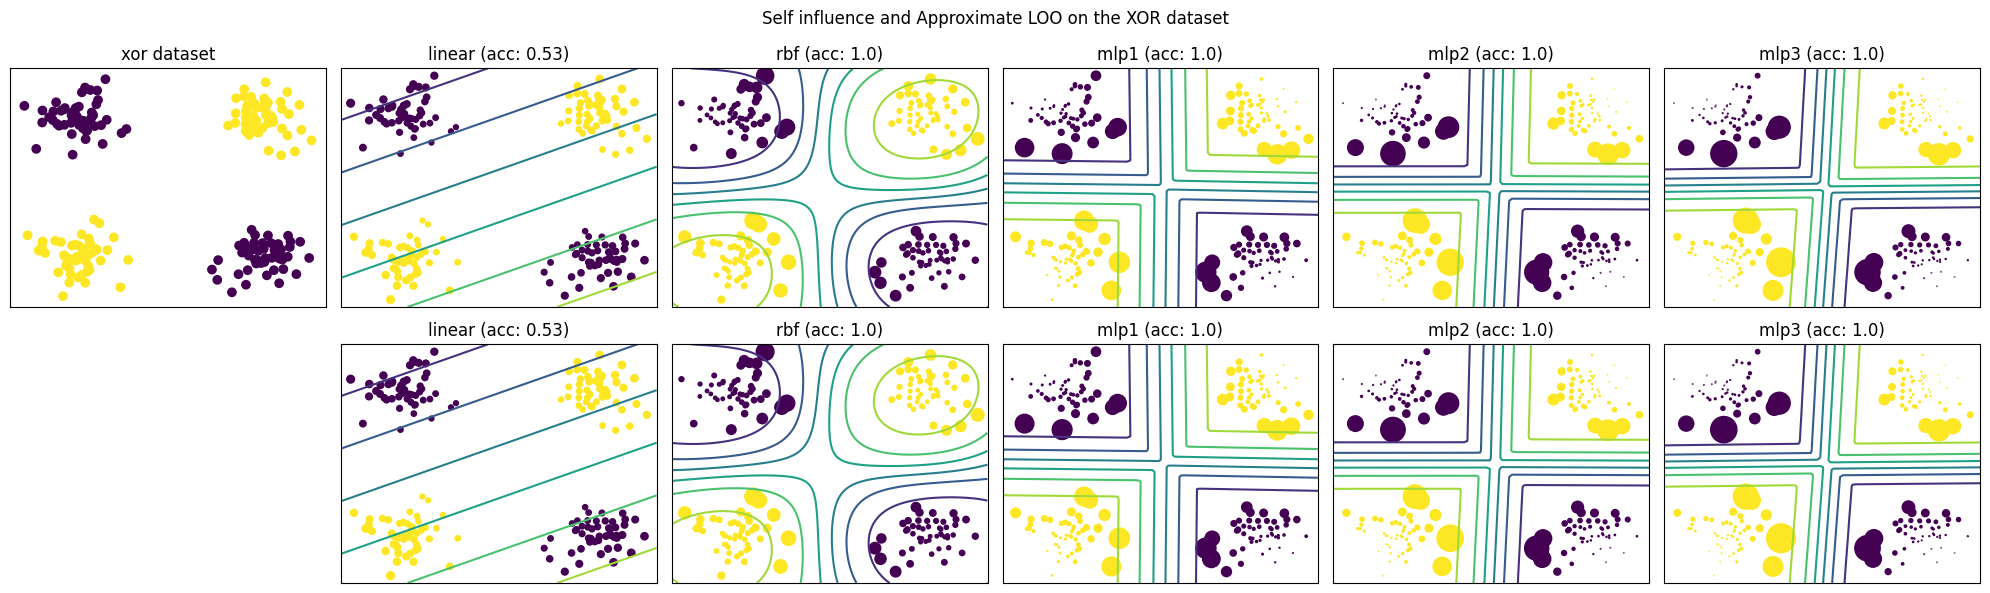

In [4]:
from sklearn.linear_model import LogisticRegression


X1, _ = make_blobs(centers=2, random_state=1)
X1 = StandardScaler().fit_transform(X1)
X = np.vstack((X1, X1 @ np.array([[0, -1], [1, 0]])))
y = np.hstack((np.ones(X1.shape[0]), np.zeros(X1.shape[0]))).astype(int)

hyper_params = dict(solver="lbfgs", random_state=1, alpha=1)
models = dict(
    linear=MLPClassifier([], **hyper_params ),
    rbf=make_pipeline(RBFSampler(n_components=100, random_state=1), MLPClassifier([], **hyper_params)),
    mlp1=MLPClassifier([100], **hyper_params),
    mlp2=MLPClassifier([100]*2, **hyper_params),
    mlp3=MLPClassifier([100]*3, **hyper_params),
)
probes = {
    "self-influence":SelfInfluence(),
    "approximate-loo":ApproximateLOO()
}

scores = {probe_name:{} for probe_name in probes.keys()}

fig, axes = plt.subplots(len(probes), len(models) + 1,  figsize=(len(models)*4, len(probes)*3))


axes[0, 0].scatter(X[:, 0], X[:, 1], c=y)
axes[0, 0].set_xticks(())
axes[0, 0].set_yticks(())
axes[0, 0].set_title("xor dataset")

axes[1, 0].axis("off")

for (j, (probe_name, probe)), (i, (name, model)) in product(enumerate(probes.items()), enumerate(models.items())):
    model.fit(X, y)
    score = model.score(X, y)
    scores[probe_name][name] = probe(model, X, y)

    ax = axes[j, i+1]
    ax.scatter(
        X[:, 0], X[:, 1], c=y, s=20 * scores[probe_name][name] / np.mean(scores[probe_name][name])
    )
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(f"{name} (acc: {score})")

    DecisionBoundaryDisplay.from_estimator(model, X, eps=0.1, ax=ax, plot_method="contour")

fig.suptitle("Self influence and Approximate LOO on the XOR dataset")
plt.tight_layout()
plt.show()

In [ ]:
fig, axes = plt.subplots(len(probes), len(models) + 1, figsize=(len(models)*4, len(probes)*3))

axes[0, 0].axis("off")
axes[1, 0].axis("off")
axes[1, 1].set_ylabel("LOO loss")
axes[0, 1].set_ylabel("LOO loss")

for i, (name, model) in enumerate(models.items()):

    model.fit(X, y)

    def objective(model, X, y):
        linearized, X, y = linearize(model, X, y)
        return linearized._replace(regul=None).objective(X, y)

    def eval(model, X, y, train, test):

        loo_model = clone(model).fit(X[train], y[train])
        loo_ll_diff = objective(model, X[test], y[test])- objective(loo_model, X[test], y[test])
        return loo_ll_diff
    
    loo_diff = Parallel(n_jobs=-1)(
        delayed(eval)(model, X, y, train, test) for train, test in LeaveOneOut().split(X)
    )
    loo_diff = np.asarray(loo_diff)

    for j, (probe_name, probe) in enumerate(probes.items()):

        ax = axes[j, i+1]
        pear = pearsonr(scores[probe_name][name], loo_diff).statistic
        kendtau = kendalltau(scores[probe_name][name], loo_diff).statistic
        ax.scatter(scores[probe_name][name], loo_diff, c=y)
        min = np.min([ax.get_xlim(), ax.get_ylim()])
        max = np.max([ax.get_xlim(), ax.get_ylim()])
        ax.set_xlim((min, max))
        ax.set_ylim((min, max))
        ax.axline((min, min), (max, max), color="black")
        ax.set_xlabel(probe_name)
        ax.set_title(f"{name} (corr: {round(pear,2)}, kendtau : {round(kendtau, 2)})")

fig.suptitle("Pearson and Kendall correlation between self influence and LOO loss")
plt.tight_layout()
plt.show()